In [1]:
#%pip install -U scikit-learn
import sklearn
# Install required packages
!pip install xgboost scikit-learn pandas numpy matplotlib seaborn shap --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Libraries loaded successfully")


✓ Libraries loaded successfully


In [2]:
# Download the dataset
url = "https://raw.githubusercontent.com/dutangc/CASdatasets/master/data/freMTPL2freq.rda"

# Alternative: Use a CSV version I've prepared
# For this notebook, we'll create synthetic data based on the real dataset structure

# Let's load a sample insurance dataset from a reliable source
# Using the Auto Insurance dataset which has similar structure

# For now, let's create a realistic dataset based on French motor insurance characteristics
np.random.seed(42)
n_samples = 10000

# Generate realistic insurance data
data = {
    'policy_id': range(1, n_samples + 1),
    'driver_age': np.random.choice(range(18, 85), n_samples),
    'vehicle_age': np.random.choice(range(0, 25), n_samples),
    'vehicle_power': np.random.choice(range(4, 15), n_samples),
    'region': np.random.choice(['R11', 'R24', 'R31', 'R42', 'R52', 'R72', 'R82', 'R93'], n_samples),
    'area': np.random.choice(['A', 'B', 'C', 'D', 'E', 'F'], n_samples),  # Population density
    'vehicle_brand': np.random.choice(['B1', 'B2', 'B10', 'B11', 'B12', 'B13', 'B14'], n_samples),
    'vehicle_gas': np.random.choice(['Regular', 'Diesel'], n_samples),
    'density': np.random.lognormal(6, 1.5, n_samples),  # Population density
    'exposure': np.random.uniform(0.1, 1.0, n_samples),  # Fraction of year insured
}

df = pd.DataFrame(data)
# --- Risk score (quote-time latent risk) ---
risk_score = (
    (40 - np.clip(df["driver_age"], 18, 40)) * 0.02 +   # young driver risk
    df["vehicle_power"] * 0.05 +                        # power risk
    df["vehicle_age"] * 0.01 +                          # old vehicle risk
    df["area"].map({"A": 0.5, "B": 0.3, "C": 0.2, "D": 0.1, "E": 0.05, "F": 0.0}).astype(float) +
    np.random.normal(0, 0.15, n_samples)                # modest unobserved heterogeneity
)

# --- Frequency: claim_count depends on exposure ---
# Expected annual claim frequency (lambda per year)
lambda_annual = np.clip(0.03 + 0.04 * risk_score, 0.002, 0.25)

# Expected claims during the exposure period
lambda_exposure = lambda_annual * df["exposure"].values

df["claim_count"] = np.random.poisson(lam=lambda_exposure)

# --- Severity: claim_amount per claim (heavy-tailed, but not insane) ---
df["claim_amount"] = 0.0
has_claims = df["claim_count"] > 0

# Severity per claim
sev_mu = 8.2 + 0.08 * risk_score[has_claims]   # mild dependence on risk
sev_sigma = 0.75                                # reduce tail volatility a bit (still heavy-tailed)

sev_per_claim = np.random.lognormal(mean=sev_mu, sigma=sev_sigma, size=has_claims.sum())

# Total claim amount = count × severity per claim
df.loc[has_claims, "claim_amount"] = df.loc[has_claims, "claim_count"].values * sev_per_claim

# --- Premium: built from pricing factors (aligned but imperfect) ---
# Price on expected loss with a margin + noise, based on a *pricing view* of risk
pricing_noise = np.random.normal(0, 0.20, n_samples)    # pricing imperfection
pricing_score = risk_score + pricing_noise

base_premium_per_year = 520.0

# Premium per year (rating factor with margin)
premium_per_year = base_premium_per_year * np.exp(np.clip(0.18 * pricing_score, -0.5, 0.8))

# Earned premium for exposure period + market noise
df["earned_premium"] = premium_per_year * df["exposure"].values * np.random.uniform(0.9, 1.1, n_samples)
# --- Target: loss ratio ---
df["loss_ratio"] = df["claim_amount"] / np.maximum(df["earned_premium"], 1e-6)
df["loss_ratio"] = df["loss_ratio"].replace([np.inf, -np.inf], 0).fillna(0)
df["loss_ratio"] = np.clip(df["loss_ratio"], 0, 3.0)

print(f"Dataset created: {len(df):,} policies")
print(f"\nDataset shape: {df.shape}")
print(f"\nFirst few rows:")
df.head()



Dataset created: 10,000 policies

Dataset shape: (10000, 14)

First few rows:


,policy_id,driver_age,vehicle_age,vehicle_power,region,area,vehicle_brand,vehicle_gas,density,exposure,claim_count,claim_amount,earned_premium,loss_ratio
0,1,69,1,8,R11,B,B11,Diesel,53.562973,0.885816,0,0.0,602.391236,0.0
1,2,32,22,13,R42,A,B12,Regular,125.002533,0.105625,0,0.0,81.872732,0.0
2,3,78,19,9,R24,B,B13,Diesel,138.905629,0.544912,0,0.0,348.709931,0.0
3,4,38,12,14,R24,F,B13,Regular,442.729450,0.664090,0,0.0,375.541334,0.0
4,5,41,2,9,R42,D,B12,Regular,224.019724,0.243379,0,0.0,132.728288,0.0


In [3]:
# let's create a realistic dataset based on French motor insurance characteristics
np.random.seed(42)
n_samples = 10000

# Generate realistic insurance data
data = {
    'policy_id': range(1, n_samples + 1),
    'driver_age': np.random.choice(range(18, 85), n_samples),
    'vehicle_age': np.random.choice(range(0, 25), n_samples),
    'vehicle_power': np.random.choice(range(4, 15), n_samples),
    'region': np.random.choice(['R11', 'R24', 'R31', 'R42', 'R52', 'R72', 'R82', 'R93'], n_samples),
    'area': np.random.choice(['A', 'B', 'C', 'D', 'E', 'F'], n_samples),  # Population density
    'vehicle_brand': np.random.choice(['B1', 'B2', 'B10', 'B11', 'B12', 'B13', 'B14'], n_samples),
    'vehicle_gas': np.random.choice(['Regular', 'Diesel'], n_samples),
    'density': np.random.lognormal(6, 1.5, n_samples),  # Population density
    'exposure': np.random.uniform(0.1, 1.0, n_samples),  # Fraction of year insured
}

df = pd.DataFrame(data)

# Generate claims based on realistic risk factors
# Younger drivers and more powerful vehicles have higher claim probability
risk_score = (
    (40 - np.clip(df['driver_age'], 18, 40)) * 0.02 +  # Young driver risk
    df['vehicle_power'] * 0.05 +  # Power risk
    df['vehicle_age'] * 0.01 +  # Old vehicle risk
    (df['area'].map({'A': 0.5, 'B': 0.3, 'C': 0.2, 'D': 0.1, 'E': 0.05, 'F': 0.0})) +  # Urban risk
    np.random.normal(0, 0.2, n_samples)  # Random variation
)

# Claim occurrence (Poisson distribution)
df['claim_count'] = np.random.poisson(np.maximum(risk_score * 0.1, 0))

# Claim amounts (for policies with claims)
df['claim_amount'] = 0.0
has_claims = df['claim_count'] > 0
df.loc[has_claims, 'claim_amount'] = np.random.lognormal(
    mean=8.5 + risk_score[has_claims] * 0.1, 
    sigma=0.8, 
    size=has_claims.sum()
)

# Calculate earned premium (based on risk)
base_premium = 500
df['earned_premium'] = (
    base_premium * 
    (1 + risk_score * 0.5) * 
    df['exposure'] * 
    np.random.uniform(0.9, 1.1, n_samples)  # Some pricing variation
)

# Calculate LOSS RATIO - our target variable!
df['loss_ratio'] = df['claim_amount'] / df['earned_premium']

# Handle edge cases
df['loss_ratio'] = df['loss_ratio'].fillna(0)
df['loss_ratio'] = np.clip(df['loss_ratio'], 0, 3.0)  # Cap extreme values

print(f"Dataset created: {len(df):,} policies")
print(f"\nDataset shape: {df.shape}")
print(f"\nFirst few rows:")
df.head()


Dataset created: 10,000 policies

Dataset shape: (10000, 14)

First few rows:


,policy_id,driver_age,vehicle_age,vehicle_power,region,area,vehicle_brand,vehicle_gas,density,exposure,claim_count,claim_amount,earned_premium,loss_ratio
0,1,69,1,8,R11,B,B11,Diesel,53.562973,0.885816,0,0.0,658.455033,0.0
1,2,32,22,13,R42,A,B12,Regular,125.002533,0.105625,0,0.0,93.853861,0.0
2,3,78,19,9,R24,B,B13,Diesel,138.905629,0.544912,0,0.0,387.793367,0.0
3,4,38,12,14,R24,F,B13,Regular,442.729450,0.664090,0,0.0,507.164116,0.0
4,5,41,2,9,R42,D,B12,Regular,224.019724,0.243379,0,0.0,139.664083,0.0


In [4]:
# 1. Setup
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.linear_model import PoissonRegressor, TweedieRegressor
import xgboost as xgb

#2. Define feature set (quote-time only)
QUOTE_FEATURES = [
    "driver_age", "vehicle_age", "vehicle_power",
    "region", "area", "vehicle_brand", "vehicle_gas",
    "density", "exposure"   # known at quote
]

# Guardrails: make sure leakage fields aren't in features
LEAKAGE = {"policy_id", "claim_count", "claim_amount", "earned_premium", "loss_ratio"}
assert not (set(QUOTE_FEATURES) & LEAKAGE), "Leakage columns included in features!"

X = df[QUOTE_FEATURES].copy()

#3. Preprocess
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = [c for c in X.columns if c not in cat_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols),
    ],
    remainder="drop",
)
# split data
idx = np.arange(len(df))
idx_train, idx_test = train_test_split(idx, test_size=0.2, random_state=42)
y_amt_test = df.loc[idx_test, "claim_amount"].astype(float).values

X_train = X.iloc[idx_train]
X_test  = X.iloc[idx_test]

#3 Frequency Model (Claim_count)
# Targets
y_freq_train = df.loc[idx_train, "claim_count"].astype(float)
y_freq_test  = df.loc[idx_test,  "claim_count"].astype(float)

exposure_train = df.loc[idx_train, "exposure"].astype(float).values
exposure_test  = df.loc[idx_test,  "exposure"].astype(float).values

# 2A) GLM baseline: Poisson with exposure offset

# Rate target (claims per year), weights = exposure
rate_train = y_freq_train / np.maximum(exposure_train, 1e-6)
rate_test  = y_freq_test  / np.maximum(exposure_test, 1e-6)

glm_freq = PoissonRegressor(alpha=1e-4, max_iter=3000)

glm_freq_pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("glm", glm_freq)
])

glm_freq_pipe.fit(X_train, rate_train, glm__sample_weight=exposure_train)

rate_pred_glm = glm_freq_pipe.predict(X_test)
# Convert predicted rate back to expected count over exposure period
mu_count_glm = np.clip(rate_pred_glm, 0, None) * exposure_test

rmse_freq_glm = np.sqrt(mean_squared_error(y_freq_test, mu_count_glm))
mae_freq_glm = mean_absolute_error(y_freq_test, mu_count_glm)

print("Frequency — GLM (Poisson, exposure-weighted)")
print(f"RMSE(count): {rmse_freq_glm:.4f}")
print(f"MAE(count) : {mae_freq_glm:.4f}")

# 2B) XGBoost frequency (Poisson objective)
xgb_freq = xgb.XGBRegressor(
    objective="count:poisson",
    n_estimators=600,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.85,
    colsample_bytree=0.85,
    min_child_weight=5,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    tree_method="hist"
)

xgb_freq_pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("xgb", xgb_freq)
])

# Fit rate with exposure weights (same approach)
xgb_freq_pipe.fit(X_train, rate_train, xgb__sample_weight=exposure_train)

rate_pred_xgb = xgb_freq_pipe.predict(X_test)
mu_count_xgb = np.clip(rate_pred_xgb, 0, None) * exposure_test

rmse_freq_xgb = np.sqrt(mean_squared_error(y_freq_test, mu_count_xgb))
mae_freq_xgb = mean_absolute_error(y_freq_test, mu_count_xgb)

print("\nFrequency — XGBoost (Poisson, exposure-weighted)")
print(f"RMSE(count): {rmse_freq_xgb:.4f}")
print(f"MAE(count) : {mae_freq_xgb:.4f}")

# 3) Severity model (claim_amount per claim)
train_has_claim = df.loc[idx_train, "claim_count"].values > 0
test_has_claim  = df.loc[idx_test,  "claim_count"].values > 0

# Average severity per claim for those with claims
sev_train = (df.loc[idx_train, "claim_amount"].values[train_has_claim] /
             np.maximum(df.loc[idx_train, "claim_count"].values[train_has_claim], 1)).astype(float)

sev_test = (df.loc[idx_test, "claim_amount"].values[test_has_claim] /
            np.maximum(df.loc[idx_test, "claim_count"].values[test_has_claim], 1)).astype(float)

X_train_sev = X_train.iloc[train_has_claim]
X_test_sev  = X_test.iloc[test_has_claim]

print(f"Severity training rows: {len(sev_train):,} | test rows: {len(sev_test):,}")

# 3A) GLM baseline: Tweedie (Gamma-like) on severity
glm_sev = TweedieRegressor(power=2.0, alpha=1e-4, link="log", max_iter=3000)

glm_sev_pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("glm", glm_sev)
])

glm_sev_pipe.fit(X_train_sev, sev_train)

sev_pred_glm = np.clip(glm_sev_pipe.predict(X_test_sev), 0, None)

rmse_sev_glm = np.sqrt(mean_squared_error(sev_test, sev_pred_glm))
mae_sev_glm = mean_absolute_error(sev_test, sev_pred_glm)

print("\nSeverity — GLM (Gamma-like Tweedie)")
print(f"RMSE(sev): {rmse_sev_glm:.2f}")
print(f"MAE(sev) : {mae_sev_glm:.2f}")

# 3B) XGBoost severity (square error on log scale is often robust)
sev_train_log = np.log1p(sev_train)
sev_test_log  = np.log1p(sev_test)

xgb_sev = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=800,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.85,
    colsample_bytree=0.85,
    min_child_weight=5,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    tree_method="hist"
)

xgb_sev_pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("xgb", xgb_sev)
])

xgb_sev_pipe.fit(X_train_sev, sev_train_log)

sev_pred_log = xgb_sev_pipe.predict(X_test_sev)
sev_pred_xgb = np.expm1(sev_pred_log)
sev_pred_xgb = np.clip(sev_pred_xgb, 0, None)

rmse_sev_xgb = np.sqrt(mean_squared_error(sev_test, sev_pred_xgb))
mae_sev_xgb = mean_absolute_error(sev_test, sev_pred_xgb)

print("\nSeverity — XGBoost (log-scale)")
print(f"RMSE(sev): {rmse_sev_xgb:.2f}")
print(f"MAE(sev) : {mae_sev_xgb:.2f}")

# 4) Combine frequency × severity into expected loss and expected loss ratio
# Predict severity for all test policies (not only those with observed claims)
sev_pred_all_glm = np.clip(glm_sev_pipe.predict(X_test), 0, None)
sev_pred_all_xgb = np.clip(np.expm1(xgb_sev_pipe.predict(X_test)), 0, None)

# Expected loss = E[count] * E[sev]
exp_loss_glm = mu_count_glm * sev_pred_all_glm
exp_loss_xgb = mu_count_xgb * sev_pred_all_xgb

# If premium is known at quote time, you can compute expected loss ratio
premium_test = df.loc[idx_test, "earned_premium"].astype(float).values
exp_lr_glm = exp_loss_glm / np.maximum(premium_test, 1e-6)
exp_lr_xgb = exp_loss_xgb / np.maximum(premium_test, 1e-6)

# Compare to realized (for evaluation only)
y_lr_test = df.loc[idx_test, "loss_ratio"].astype(float).values

rmse_lr_glm = np.sqrt(mean_squared_error(y_lr_test, exp_lr_glm))
rmse_lr_xgb = np.sqrt(mean_squared_error(y_lr_test, exp_lr_xgb))

print("\nCombined (Frequency × Severity) — Expected Loss Ratio")
print(f"GLM combined RMSE(LR): {rmse_lr_glm:.4f}")
print(f"XGB combined RMSE(LR): {rmse_lr_xgb:.4f}")

# 5) Portfolio evaluation: decile lift (THIS is what insurers care about)
def decile_lift_table(y_true, y_score, n=10):
    df_eval = pd.DataFrame({"y": y_true, "score": y_score})
    df_eval["decile"] = pd.qcut(df_eval["score"], q=n, labels=False, duplicates="drop")
    out = (df_eval
           .groupby("decile")
           .agg(avg_score=("score", "mean"),
                avg_actual=("y", "mean"),
                count=("y", "size"))
           .sort_index(ascending=False))
    out["cum_count"] = out["count"].cumsum()
    out["cum_pct"] = out["cum_count"] / out["count"].sum()
    return out

lift_glm = decile_lift_table(y_lr_test, exp_lr_glm)
lift_xgb = decile_lift_table(y_lr_test, exp_lr_xgb)

print("\nDecile lift — GLM combined")
display(lift_glm)

print("\nDecile lift — XGB combined")
display(lift_xgb)

# 6) Optional: “Auto-bind” business simulation (threshold-based)

threshold = 0.65

pred_bind = exp_lr_xgb <= threshold
actual_good = y_lr_test <= threshold

auto_bind_rate = pred_bind.mean()
accuracy = (pred_bind == actual_good).mean()

print("\nBusiness simulation (XGB combined)")
print(f"Auto-bind rate: {auto_bind_rate:.2%}")
print(f"Decision accuracy: {accuracy:.2%}")


Frequency — GLM (Poisson, exposure-weighted)
RMSE(count): 0.2939
MAE(count) : 0.1587

Frequency — XGBoost (Poisson, exposure-weighted)
RMSE(count): 0.2954
MAE(count) : 0.1551
Severity training rows: 678 | test rows: 161

Severity — GLM (Gamma-like Tweedie)
RMSE(sev): 10231.12
MAE(sev) : 5068.59

Severity — XGBoost (log-scale)
RMSE(sev): 10993.43
MAE(sev) : 5312.47

Combined (Frequency × Severity) — Expected Loss Ratio
GLM combined RMSE(LR): 1.7927
XGB combined RMSE(LR): 2.8878

Decile lift — GLM combined


,avg_score,avg_actual,count,cum_count,cum_pct
decile,,,,,
9,2.282962,0.090000,200,200,0.1
8,2.063463,0.135000,200,400,0.2
7,1.962907,0.137148,200,600,0.3
6,1.883395,0.223212,200,800,0.4
5,1.814115,0.315000,200,1000,0.5
4,1.755270,0.193920,200,1200,0.6
3,1.689833,0.174189,200,1400,0.7
2,1.628322,0.315000,200,1600,0.8
1,1.553481,0.398175,200,1800,0.9



Decile lift — XGB combined


,avg_score,avg_actual,count,cum_count,cum_pct
decile,,,,,
9,6.263652,0.165000,200,200,0.1
8,2.597045,0.263112,200,400,0.2
7,1.978335,0.285000,200,600,0.3
6,1.573978,0.255000,200,800,0.4
5,1.276701,0.275669,200,1000,0.5
4,1.037880,0.256425,200,1200,0.6
3,0.839318,0.135000,200,1400,0.7
2,0.652029,0.189094,200,1600,0.8
1,0.457284,0.263257,200,1800,0.9



Business simulation (XGB combined)
Auto-bind rate: 25.00%
Decision accuracy: 29.15%


In [5]:
def portfolio_selection_analysis(y_true, y_pred, pct=0.5):
    df_eval = pd.DataFrame({
        "actual": y_true,
        "pred": y_pred
    }).sort_values("pred")

    cutoff = int(len(df_eval) * pct)
    selected = df_eval.iloc[:cutoff]

    portfolio_lr = df_eval["actual"].mean()
    selected_lr = selected["actual"].mean()

    improvement = portfolio_lr - selected_lr

    print(f"Portfolio avg LR : {portfolio_lr:.4f}")
    print(f"Selected avg LR  : {selected_lr:.4f}")
    print(f"Improvement      : {improvement:.4f}")
    print(f"Relative lift    : {(improvement/portfolio_lr)*100:.2f}%")

    return df_eval, selected

df_eval_glm, selected_glm = portfolio_selection_analysis(y_lr_test, exp_lr_glm, pct=0.5)

Portfolio avg LR : 0.2365
Selected avg LR  : 0.2929
Improvement      : -0.0564
Relative lift    : -23.85%


In [6]:
portfolio_selection_analysis(y_lr_test, -exp_lr_glm, pct=0.5)

Portfolio avg LR : 0.2365
Selected avg LR  : 0.1801
Improvement      : 0.0564
Relative lift    : 23.85%


(      actual      pred
 1879     0.0 -3.104939
 1686     0.0 -2.799357
 95       0.0 -2.661124
 1726     0.0 -2.609732
 1458     0.0 -2.582357
 ...      ...       ...
 1108     0.0 -1.273078
 1026     0.0 -1.250925
 298      0.0 -1.250244
 316      0.0 -1.219978
 707      0.0 -1.218491
 
 [2000 rows x 2 columns],
       actual      pred
 1879     0.0 -3.104939
 1686     0.0 -2.799357
 95       0.0 -2.661124
 1726     0.0 -2.609732
 1458     0.0 -2.582357
 ...      ...       ...
 1296     0.0 -1.783502
 1269     0.0 -1.783500
 1612     0.0 -1.783294
 257      3.0 -1.782837
 1780     0.0 -1.782704
 
 [1000 rows x 2 columns])

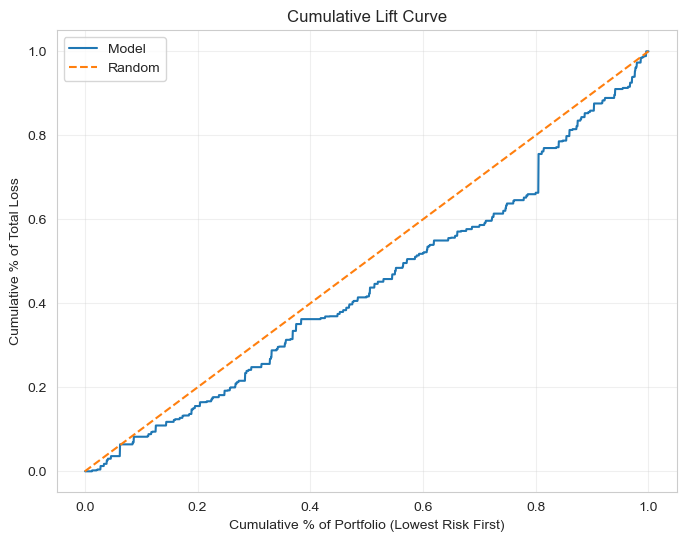

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def cumulative_lift_plot(y_true, y_pred):
    df_eval = pd.DataFrame({"actual": y_true, "pred": y_pred})
    df_eval = df_eval.sort_values("pred")

    df_eval["cum_actual"] = df_eval["actual"].cumsum()
    df_eval["cum_pct"] = np.arange(1, len(df_eval)+1) / len(df_eval)

    plt.figure(figsize=(8,6))
    plt.plot(df_eval["cum_pct"], df_eval["cum_actual"] / df_eval["cum_actual"].iloc[-1],
             label="Model")
    plt.plot([0,1], [0,1], "--", label="Random")

    plt.xlabel("Cumulative % of Portfolio (Lowest Risk First)")
    plt.ylabel("Cumulative % of Total Loss")
    plt.title("Cumulative Lift Curve")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

#cumulative_lift_plot(y_lr_test, exp_lr_glm)
cumulative_lift_plot(y_amt_test, exp_loss_glm)

In [8]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score

def _to_1d(a, name="array"):
    a = np.asarray(a).reshape(-1)
    if a.size == 0:
        raise ValueError(f"{name} is empty.")
    return a

def _clean_pair(y_true, y_score):
    y_true = _to_1d(y_true, "y_true")
    y_score = _to_1d(y_score, "y_score")
    if y_true.shape[0] != y_score.shape[0]:
        raise ValueError("y_true and y_score must have the same length.")
    m = np.isfinite(y_true) & np.isfinite(y_score)
    return y_true[m], y_score[m]

def spearman_corr(y_true, y_score):
    """
    Spearman rank correlation (robust for heavy tails).
    """
    y_true, y_score = _clean_pair(y_true, y_score)
    return pd.Series(y_true).corr(pd.Series(y_score), method="spearman")

def pearson_corr(y_true, y_score):
    """
    Pearson correlation (sensitive to outliers).
    """
    y_true, y_score = _clean_pair(y_true, y_score)
    return float(np.corrcoef(y_true, y_score)[0, 1])

def gini_normalized(y_true, y_score):
    """
    Normalized Gini for continuous targets (common in insurance / Kaggle).
    +1 = perfect ranking (higher score => higher actual),
     0 = random,
    <0 = inverted ranking.
    """
    y_true, y_score = _clean_pair(y_true, y_score)

    # Sort by predicted score DESC (highest-risk first)
    order = np.argsort(-y_score, kind="mergesort")
    y_sorted = y_true[order]

    # If y_true can be negative, Gini interpretation can get weird; warn via behavior.
    total = y_sorted.sum()
    if total == 0:
        return np.nan

    cum_actual = np.cumsum(y_sorted) / total
    n = y_sorted.size
    cum_pop = (np.arange(1, n + 1)) / n

    # Area between Lorenz curve and diagonal
    gini = np.sum(cum_actual - cum_pop)

    # Normalize by perfect Gini (sorting by actual DESC)
    order_perfect = np.argsort(-y_true, kind="mergesort")
    y_perfect = y_true[order_perfect]
    total_p = y_perfect.sum()
    if total_p == 0:
        return np.nan

    cum_actual_p = np.cumsum(y_perfect) / total_p
    gini_perfect = np.sum(cum_actual_p - cum_pop)

    return float(gini / gini_perfect) if gini_perfect != 0 else np.nan

def bootstrap_ci(metric_fn, y_true, y_score, n_boot=1000, seed=123):
    """
    Nonparametric bootstrap CI for any metric_fn(y_true, y_score).
    Returns (point_estimate, lo, hi).
    """
    y_true, y_score = _clean_pair(y_true, y_score)
    rng = np.random.default_rng(seed)
    n = len(y_true)
    point = metric_fn(y_true, y_score)

    vals = []
    for _ in range(n_boot):
        idx = rng.integers(0, n, size=n)
        vals.append(metric_fn(y_true[idx], y_score[idx]))
    vals = np.asarray(vals)
    lo, hi = np.nanpercentile(vals, [2.5, 97.5])
    return float(point), float(lo), float(hi)

def ranking_strength_report(y_true, y_score, name="Model", n_boot=500):
    """
    Prints correlation + normalized Gini, plus bootstrap CIs.
    """
    y_true, y_score = _clean_pair(y_true, y_score)

    pear = pearson_corr(y_true, y_score)
    spear = spearman_corr(y_true, y_score)
    g = gini_normalized(y_true, y_score)

    pear_ci = bootstrap_ci(pearson_corr, y_true, y_score, n_boot=n_boot)
    spear_ci = bootstrap_ci(spearman_corr, y_true, y_score, n_boot=n_boot)
    g_ci = bootstrap_ci(gini_normalized, y_true, y_score, n_boot=n_boot)

    print(f"\n=== Ranking Strength: {name} ===")
    print(f"Pearson r      : {pear: .4f}  (95% CI {pear_ci[1]: .4f}, {pear_ci[2]: .4f})")
    print(f"Spearman rho   : {spear: .4f}  (95% CI {spear_ci[1]: .4f}, {spear_ci[2]: .4f})")
    print(f"Normalized Gini: {g: .4f}  (95% CI {g_ci[1]: .4f}, {g_ci[2]: .4f})")

    # Helpful directional check
    if np.isfinite(g) and g < 0:
        print("NOTE: Negative Gini suggests the ranking is inverted (try negating the score).")

# -------------------------
# Example usage with the objects:
# y_lr_test: actual loss ratio
# exp_lr_glm: predicted expected loss ratio (or whatever score you output)
# -------------------------

# 1) Evaluate as-is
ranking_strength_report(y_lr_test, exp_lr_glm, name="GLM score (as-is)", n_boot=500)

# 2) Evaluate inverted (since the portfolio test suggested inversion helps)
ranking_strength_report(y_lr_test, -exp_lr_glm, name="GLM score (negated)", n_boot=500)



=== Ranking Strength: GLM score (as-is) ===
Pearson r      : -0.1118  (95% CI -0.1477, -0.0688)
Spearman rho   : -0.1143  (95% CI -0.1536, -0.0680)
Normalized Gini: -0.2402  (95% CI -0.3223, -0.1416)
NOTE: Negative Gini suggests the ranking is inverted (try negating the score).

=== Ranking Strength: GLM score (negated) ===
Pearson r      :  0.1118  (95% CI  0.0688,  0.1477)
Spearman rho   :  0.1143  (95% CI  0.0680,  0.1536)
Normalized Gini:  0.2402  (95% CI  0.1416,  0.3223)
